# Regresión Logística

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

#### Leer los datos

In [2]:
# Leer los datos
df = pd.read_csv("train.csv")

# Selección de variables
variables_numericas = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'YearBuilt', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'SalePrice'
]
df = df[variables_numericas]

#### Clasificación de Precios

In [3]:
# Clasificación de precios
p40 = df['SalePrice'].quantile(0.40)
p90 = df['SalePrice'].quantile(0.90)

def clasificar_precio(precio):
    if precio <= p40:
        return "Económica"
    elif precio <= p90:
        return "Intermedia"
    else:
        return "Cara"

#### Variables Dicotómicas

In [4]:
df['CategoriaPrecio'] = df['SalePrice'].apply(clasificar_precio)
df['Es_Cara'] = (df['CategoriaPrecio'] == 'Cara').astype(int)

#### Varables predictoras y respuesta

In [5]:
# Definir variables predictoras y respuesta
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara'])
y = df['Es_Cara']

#### Separar en modelos de entrenamiento y prueba

In [6]:
# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=42, stratify=y
)

#### Modelo de Regresión Logística

In [7]:
# Modelo de regresión logística
modelo = LogisticRegression(solver='liblinear')
modelo.fit(X_train, y_train)

# Predicciones y Probabilidades de predicción
y_proba = modelo.predict_proba(X_test)[:, 1]

# Nuevo umbral de decisión
umbral = 0.35
y_pred = (y_proba >= umbral).astype(int)

#### Métricas y Resultados

Accuracy: 0.95
Precisión: 0.75
Recall: 0.82
F1 Score: 0.78
Precisión promedio (validación cruzada): 0.95


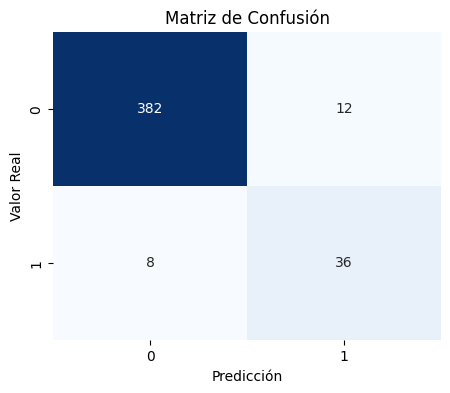

In [12]:
# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cv = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')

# Resultados
print(f"Accuracy: {accuracy:.2f}")
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precisión promedio (validación cruzada): {cv.mean():.2f}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

#### Análisis de Multicolinealidad

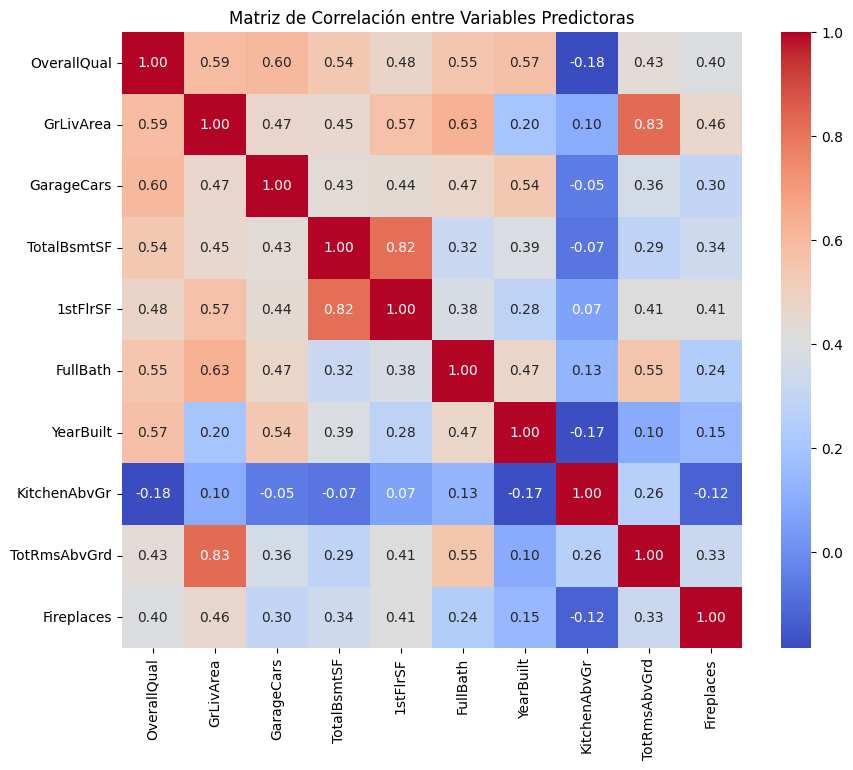

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables Predictoras")
plt.show()

<small>

#### **Análisis del modelo: multicolinealidad, significancia y ajuste**

Se examinó la matriz de correlación entre las variables numéricas del modelo. Se encontró una alta correlación entre:

- TotalBsmtSF y 1stFlrSF (r = 0.82)

- GrLivArea y TotRmsAbvGrd (r = 0.83)

Estas correlaciones superiores a 0.80 podrían indicar multicolinealidad, lo cual puede afectar la estabilidad de los coeficientes en modelos lineales o logísticos. A pesar de esto, no se observa una afectación fuerte en los resultados del modelo, pero sería recomendable considerar eliminar o combinar variables altamente correlacionadas si se quiere mejorar la robustez del modelo.

</small>

#### Análisis de Significancia de las Variables

In [20]:
X_const = sm.add_constant(X)  
modelo_logit = sm.Logit(y, X_const)
resultado = modelo_logit.fit()

print(resultado.summary())

Optimization terminated successfully.
         Current function value: 0.106224
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                Es_Cara   No. Observations:                 1460
Model:                          Logit   Df Residuals:                     1449
Method:                           MLE   Df Model:                           10
Date:                Wed, 09 Apr 2025   Pseudo R-squ.:                  0.6717
Time:                        23:42:20   Log-Likelihood:                -155.09
converged:                       True   LL-Null:                       -472.42
Covariance Type:            nonrobust   LLR p-value:                6.540e-130
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -43.1866     23.130     -1.867      0.062     -88.520       2.147
OverallQual      1.570

<small>

#### **Variables significativas (p-value < 0.05)**

Según el resumen del modelo logístico, las siguientes variables fueron estadísticamente significativas para predecir si una vivienda es "Cara":

- OverallQual (p = 0.000)
- GrLivArea (p = 0.001)
- GarageCars (p = 0.000)
- Fireplaces (p = 0.000)

Estas variables tienen un valor de p menor a 0.05, lo que indica que aportan información significativa al modelo. Las demás variables no mostraron evidencia estadística suficiente para ser consideradas influyentes en la clasificación del precio alto de una vivienda.

#### **¿El modelo se adapta bien a los datos?**

El modelo de regresión logística desarrollado para predecir si una vivienda es **cara o no** se adapta adecuadamente a los datos. Esto puede observarse principalmente en el valor del **pseudo R² de McFadden**, que fue de **0.67**. En contextos de regresión logística, este valor se considera alto, indicando que el modelo logra explicar una parte considerable de la variabilidad en la variable respuesta.

Además, el modelo **converge exitosamente**, lo cual puede observarse en el mensaje `"converged: True"` en los resultados. Esto confirma que el algoritmo de optimización logró encontrar una solución estable.

Las **métricas de evaluación** sobre el conjunto de prueba muestran un buen desempeño: **accuracy = 0.95**, **recall = 0.82**, **precisión = 0.75** y **F1 score = 0.78**. Estas métricas sugieren que el modelo es capaz de clasificar correctamente la mayoría de las observaciones, manteniendo un balance entre falsos positivos y falsos negativos.

Finalmente, se aplicó **validación cruzada (k=5)**, obteniendo una **precisión promedio también de 0.95**, lo cual refuerza que el modelo **generaliza bien** y no depende exclusivamente de los datos de entrenamiento o prueba.

En conjunto, se concluye que **el modelo se adapta bien a los datos**, con un ajuste sólido y buena capacidad de generalización.

</small>

#### Análisis de Eficiencia del Modelo

<small>

Al aplicar el modelo de regresión logística al conjunto de prueba, se obtuvo una **precisión (accuracy) del 95%**, lo cual indica que el modelo clasifica correctamente si una vivienda es cara o no en la gran mayoría de los casos. Además, el **recall fue del 82%**, lo que significa que el modelo logró identificar correctamente el 82% de las viviendas que realmente son caras. La **precisión (precision) alcanzó un valor de 75%**, lo que refleja que, de todas las viviendas clasificadas como caras, el 75% realmente lo eran. El F1-score, que representa el balance entre precisión y recall, fue de 0.78, confirmando un desempeño equilibrado.

La matriz de confusión mostró un bajo número de errores de clasificación, con solo 12 falsos positivos (viviendas clasificadas como caras cuando no lo eran) y 8 falsos negativos (viviendas caras clasificadas como no caras). Esto evidencia que el modelo tiene un buen control tanto de los falsos positivos como de los falsos negativos.

Finalmente, al aplicar validación cruzada (k=5) se obtuvo también una precisión promedio de 95%, lo cual respalda la estabilidad del modelo y su capacidad de generalizar a nuevos datos. En conjunto, estos resultados permiten concluir que el modelo es altamente eficiente para la tarea de clasificación binaria planteada.

</small>

#### ¿Hay Sobreajuste? 

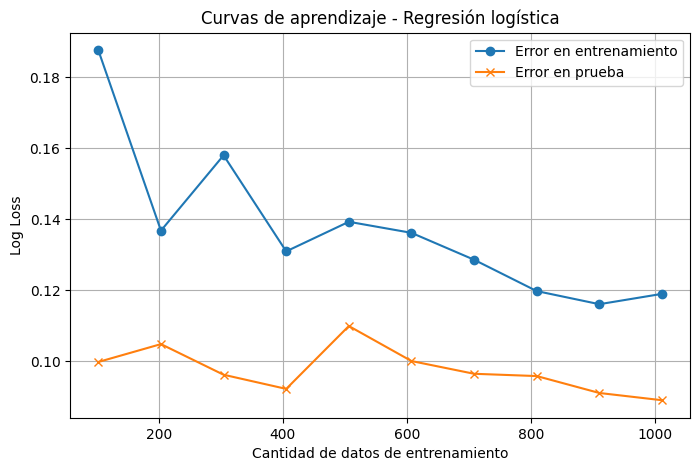

In [26]:
# División fija para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_errors = []
test_errors = []
sizes = np.linspace(0.1, 0.99, 10)  # Evitar 1.0 exacto

for frac in sizes:
    X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    model = LogisticRegression(solver='liblinear')
    model.fit(X_frac, y_frac)

    y_train_pred_proba = model.predict_proba(X_frac)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    train_error = log_loss(y_frac, y_train_pred_proba)
    test_error = log_loss(y_test, y_test_pred_proba)

    train_errors.append(train_error)
    test_errors.append(test_error)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8, 5))
plt.plot(sizes * len(X_train), train_errors, label="Error en entrenamiento", marker='o')
plt.plot(sizes * len(X_train), test_errors, label="Error en prueba", marker='x')
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Log Loss")
plt.title("Curvas de aprendizaje - Regresión logística")
plt.legend()
plt.grid(True)
plt.show()